# Board Games
## A study by Thomas KLEIN

### 1. Introduction
The board gaming hobby is incredibly rich. Thousands of games, a myriad of styles and mechanics, very different levels of complexity, incredibly creative ideas, designs and themes from their creators... The board gaming community is also very active and united, always looking to give feedback on recently-published games, create content, guides and reviews to help other players enjoy the games or join the hobby and giving time and energy to manage resources to document, support or even develop online versions of the games. I was always a board game fan, from weekend afternoons to playing with family, Wednesdays at my grandmother's playing with her and my cousins or later on, more social games with friends in high school and university. I got introduced more recently to the "serious" part of the hobby, where the games are more complex, last longer (a few hours) and require proper brain investment. Although no two games are the same and there are so many different ingenious mechanics designed by the authors to create a engaging experience, it seemed to me there would be some traits and aspects of games that I appreciate more than others and that would motivate me to play another game or try a new one.

### 2. Project
After spending time on the number one board games website BoardGameGeek and its vast resources to look at list of games, compare games I had already played, browse through others... I decided I would try to see if I can find the similarities that make it so I enjoy the games I enjoy and potentially find new games I should try based on some of those "similarities". The idea is to develop a machine learning model using data describing aspects of board games (theme, category, complexity, mechanics, desginers, etc.), feed my own subjective reviews of the games I've played (both liked and disliked) on a scale of 1 to 10, and then train, test and refine a recommendation model for myself. The challenges are to determine what are the actual features we are going to use, what kind of model and how well it would perform given the fact that the target variable would be my own subjective rating and also that I have only played and reviewed an admittedly small proportion of the whole board games catalogue.

### 3. Data
#### 3.1. Data sourcing
7 tables scraping data from the website BoardGameGeek have been gathered using this kaggle dataset link on Feb 22nd 2024.https://www.kaggle.com/datasets/mshepherd/board-games?resource=download
The data covers all games listed on the website (in the table GameItem) and 6 other tables converting identifiers to the actual description of the field (game category, game family, game type, etc.)

Additionally, I have provided my own rating of the games I have played (review and updated with 111 games on Apr 26 2024) to answer the question and try to suggest games I would potentially appreciate, and rate as high as the ones I've appreciated most.

#### 3.2. Data importing and joining
After importing the main table bgg_GameItem, we import all other tables (except GameFamily, which we are not interested in at the moment). We also import the table containing my own ratings of games (stored by game name) and make sure this are available in the list of games we scraped and will be possible to merge. We do some basic cleaning by removing some of the games that look duplicated, at least out of the ones I have rated, since that part of the dataset will be used for training and testing of the model.

In [38]:
# Perform the necessary imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import shap
import re

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
from xgboost import XGBRegressor
from pdpbox import pdp, info_plots
from sklearn.inspection import PartialDependenceDisplay
from IPython.display import display

SEED = 42

In [39]:
# Import the source data
games_df = pd.read_csv('bgg_GameItem.csv')
type_df = pd.read_csv('bgg_GameType.csv')
category_df = pd.read_csv('bgg_Category.csv')
mechanic_df = pd.read_csv('bgg_Mechanic.csv')
person_df = pd.read_csv('bgg_Person.csv')
publisher_df = pd.read_csv('bgg_Publisher.csv')
thomas_ratings_df = pd.read_csv('personal_ratings.csv',encoding='unicode_escape')
games_df.head()

,bgg_id,name,year,game_type,designer,artist,publisher,min_players,max_players,min_players_rec,...,stddev_rating,bayes_rating,complexity,language_dependency,bga_id,dbpedia_id,luding_id,spielen_id,wikidata_id,wikipedia_id
0,1,Die Macher,1986.0,5497,1,"12517,4959","133,2,24883,2726,15108,39249,11652,5382,8147",3.0,5.0,4.0,...,1.57510,7.06367,4.3144,1.166667,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Dragonmaster,1981.0,5497,8384,12424,"64,20",3.0,4.0,3.0,...,1.46752,5.76599,1.9636,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Samurai,1998.0,5497,2,11883,"17,133,267,29,7340,7335,41,2973,4617,1391,8291...",2.0,4.0,2.0,...,1.19279,7.22869,2.4784,1.006579,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Tal der Könige,1992.0,5497,8008,2277,37,2.0,4.0,2.0,...,1.23667,5.66660,2.6667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Acquire,1964.0,5497,4,"12658,18317","92,5,4871,3082,858,2962,28072,5392,4668,38,462...",2.0,6.0,3.0,...,1.33603,7.12541,2.4985,1.095890,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
thomas_ratings_df['Title'] = thomas_ratings_df['Title'].apply(lambda x: re.sub(r'\s*\(\d{4}\)', '', x))
thomas_ratings_df.head()

,Title,YourRating
0,6 nimmt!,5.0
1,7 Wonders (Second Edition),5.5
2,7 Wonders,5.5
3,Age of Innovation,8.0
4,Agricola (Revised Edition),7.5


In [41]:
# First we test if we can find all games from my ratings in the dataset. We do this by trying to join the games_df on my ratings df
test_merged_df = pd.merge(thomas_ratings_df, games_df, left_on='Title', right_on='name', how='left')
test_merged_df = test_merged_df[['Title','YourRating','bgg_id','name']]
test_merged_df[test_merged_df['bgg_id'].isna()]

,Title,YourRating,bgg_id,name
26,Civilization: A New Dawn  Terra Incognita,6.5,NaN,NaN
40,Dune: Imperium  Immortality,10.0,NaN,NaN
41,Dune: Imperium  Uprising,9.5,NaN,NaN
47,Formula DÃ©,5.5,NaN,NaN
51,Great Western Trail: Second Edition,9.5,NaN,NaN


We find 5 games that are not found in the dataset. But we know they actually are, the join failed because of syntax/spelling. We'll update those values after looking for the correct name in the dataset.

In [42]:
# Civilization game: correct name should be: 	Civilization: A New Dawn
# games_df[games_df['name'].str.contains('Civilization')].sort_values(by='rank', ascending = True)

# Dune Imperium game: actually already present without "Immortality". We can drop the row
thomas_ratings_df = thomas_ratings_df.drop(index = thomas_ratings_df[thomas_ratings_df['Title'].str.contains('Immortality')].index)

# Dune Uprising game: actually not in the list, to drop before the merge
thomas_ratings_df = thomas_ratings_df.drop(index = thomas_ratings_df[thomas_ratings_df['Title'].str.contains('Uprising')].index)

# GWT game: correct name should be: 	Great Western Trail (Second Edition)
# games_df[games_df['name'].str.contains('Great Western Trail')].sort_values(by='rank', ascending = True)

# Formule De game: correct name should be: 	Formule Dé

# Replace the contents of a cell
thomas_ratings_df.at[thomas_ratings_df[thomas_ratings_df['Title'].str.contains('Civilization: A New Dawn  Terra Incognita')].index.values[0], 'Title'] = 'Civilization: A New Dawn'

thomas_ratings_df.at[thomas_ratings_df[thomas_ratings_df['Title'].str.contains('Great Western Trail: Second Edition')].index.values[0], 'Title'] = 'Great Western Trail (Second Edition)'

thomas_ratings_df.at[thomas_ratings_df[thomas_ratings_df['Title'].str.contains('Formula DÃ©')].index.values[0], 'Title'] = 'Formule Dé'

# Join the DataFrames based on the "name" and "Title" columns
merged_df = pd.merge(games_df, thomas_ratings_df, left_on='name', right_on='Title', how='left')

After merging we notice we have some duplicated games. There are actually many in the games_df but we will at least drop the ones where ratings were provided. We look at the duplicated names and remove the ones that don't have a rank for example, or that have less data.

In [43]:
# Find the duplicated game names
# duplicated = merged_df[merged_df['name'].duplicated(keep=False)].sort_values(by='name')
# duplicated[~duplicated['YourRating'].isnull()]

# List of the bgg ids to drop
bgg_ids_to_drop = [261341,50381,205398,1653,2088,64777,286096]

# Removing those rows
merged_df = merged_df[~merged_df['bgg_id'].isin(bgg_ids_to_drop)]

### 4. Exploratory analysis and data cleaning
#### 4.1. Early exploration
To get an idea of the how complete and usable the data is, let's do some basic exploration and answer a few early questions:
- how recent is the data we are working with, are there some popular board games missing?
- what are the most complex games according to the complexity metric?
- what are some of the most popular 3 players games?

In [44]:
# Investigate the most recent games
# games_df.sort_values(by='year', ascending = False)

# We actually see some games with dates in the future (2025, 2026...). We will keep those for now.

# We also check for a few good recent games (Ark Nova, Age of Innovation, Wonderland's War, Heat...)
# games_df[games_df['name'].str.contains('Ark')].sort_values(by='rank', ascending = True)

# They're all present in the dataset.

In [45]:
# Show the top 25 most complex games
complex_games = games_df[['bgg_id','name','year','complexity','category','rank','avg_rating', 'min_players_best', 'max_players_best','min_time','max_time','num_votes']]
# complex_games.head()

# Remove predominant war games
war_categories = ['1019','1049']
complex_games_not_war = complex_games[complex_games['category'].str.contains('|'.join(war_categories))==False]
# complex_games_not_war.head(25)

# Define coniditions to remove fringe games and oonly keep top 1000 games
conditions_not_war =  (complex_games_not_war['num_votes'] >= 100) & (complex_games_not_war['rank'] <=1000)
complex_games_not_war[conditions_not_war].sort_values(by='complexity', ascending = False).head(10)

,bgg_id,name,year,complexity,category,rank,avg_rating,min_players_best,max_players_best,min_time,max_time,num_votes
88006,281655,High Frontier 4 All,2020.0,4.8218,"1015,1021,1020,1088,1016,1113",971.0,8.48309,3.0,3.0,30.0,240.0,1260.0
79963,242705,Aeon Trespass: Odyssey,2022.0,4.7301,"1022,1050,1015,1021,1020,1010,1047,1082,1016",735.0,9.33593,1.0,2.0,90.0,90.0,1619.0
68755,184267,On Mars,2020.0,4.6726,"1029,1021,1020,1016,1113,1086",48.0,8.21863,3.0,3.0,90.0,150.0,11024.0
63336,163839,Feudum,2017.0,4.6008,"1022,1021,1010,1035",674.0,7.61842,4.0,4.0,80.0,180.0,3512.0
60891,154825,Arkwright,2014.0,4.5954,"1021,1088",686.0,7.80499,4.0,4.0,120.0,240.0,2384.0
62695,161533,Lisboa,2017.0,4.5946,"1029,1021,1088,1001",58.0,8.18995,3.0,3.0,60.0,120.0,9932.0
78914,237179,Weather Machine,2022.0,4.5670,1016,794.0,7.89857,3.0,3.0,60.0,150.0,2226.0
94082,308119,Pax Renaissance: 2nd Edition,2021.0,4.5541,"2725,1070",703.0,8.60020,2.0,3.0,60.0,120.0,1414.0
71784,198953,Pax Renaissance,2016.0,4.4562,"1094,2725,1115,1070",616.0,8.01748,3.0,3.0,60.0,120.0,2272.0
68159,182028,Through the Ages: A New Story of Civilization,2015.0,4.4311,"1002,1015,1021",13.0,8.31631,3.0,3.0,120.0,120.0,29638.0


In [46]:
three_p_games = games_df[(games_df['min_players_best']==3 ) & (games_df['max_players_best']==3)]
col_to_drop = ['designer', 'artist', 'publisher' ,'min_players','max_players','min_players_rec','max_players_rec','min_age','min_age_rec', 'min_time', 'max_time', 'game_type','mechanic', 'category','cooperative','num_votes', 'compilation','compilation_of', 'family','implementation','integration','stddev_rating','bayes_rating','language_dependency',
       'bga_id', 'dbpedia_id', 'luding_id', 'spielen_id', 'wikidata_id',
       'wikipedia_id'] 
three_p_games = three_p_games.drop(columns= col_to_drop, axis = 1)
three_p_games.sort_values(by='rank', ascending = True).head(10)

,bgg_id,name,year,min_players_best,max_players_best,rank,avg_rating,complexity
66014,174430,Gloomhaven,2017.0,3.0,3.0,3.0,8.62311,3.8959
64190,167791,Terraforming Mars,2016.0,3.0,3.0,6.0,8.37817,3.2566
68159,182028,Through the Ages: A New Story of Civilization,2015.0,3.0,3.0,13.0,8.31631,4.4311
70787,193738,Great Western Trail,2016.0,3.0,3.0,15.0,8.23164,3.7040
67016,177736,A Feast for Odin,2016.0,3.0,3.0,23.0,8.17666,3.8559
85006,266192,Wingspan,2019.0,3.0,3.0,25.0,8.07313,2.4542
95042,312484,Lost Ruins of Arnak,2020.0,3.0,3.0,29.0,8.08185,2.9035
71923,199792,Everdell,2018.0,3.0,3.0,31.0,8.05634,2.8056
102273,341169,Great Western Trail (Second Edition),2021.0,3.0,3.0,35.0,8.42493,3.7303
70379,192135,Too Many Bones,2017.0,3.0,3.0,38.0,8.35324,3.8538


#### 4.2. Fields (attribute) observation and selection
##### 4.2.1. First look
A first look at all the features we have available let's us know that they will probably not all matter as much. Considering the amount of different categories, game types, mechanics and designers, artists and publishers, we'll need to re-focus our scope of analysis, especially since we only have about 110 games with the target variable of my own rating defined out od 100,000 games total. A first culling of variables is performed to remove attributes that could be interesting but are unlikely to either be complete in the data or telling for the outcome. We do this using our best knowledge of board games and what we want to focus the recommendation model on. The columns with data containing the designer, artist or published are removed, so are the the columns about min and max time and age as well the number of players (but we keep the min and max number of player estimated as "best" by users of the BGG website).
Then we count the total number of available rows and the overall completion of the remaining fields.



Now let's clean up the dataset, starting by removing the columns we will not use to build the model on.

In [47]:
# Dropping columns that are unlikely to have to important impact on the outcome (rating) or where data would be too sparse in the dataset.
columns_to_drop = ['designer', 'artist', 'publisher' ,'min_players','max_players','min_players_rec','max_players_rec','min_age','min_age_rec', 'min_time', 'max_time', 'compilation','compilation_of', 'family','implementation','integration','stddev_rating','bayes_rating','language_dependency',
       'bga_id', 'dbpedia_id', 'luding_id', 'spielen_id', 'wikidata_id',
       'wikipedia_id']
merged_df_slim = merged_df.drop(columns= columns_to_drop, axis = 1)
merged_df_slim.head()

,bgg_id,name,year,game_type,min_players_best,max_players_best,category,mechanic,cooperative,rank,num_votes,avg_rating,complexity,Title,YourRating
0,1,Die Macher,1986.0,5497,5.0,5.0,"1021,1026,1001","2916,2080,2012,2072,2040,2020",NaN,369.0,5632.0,7.60139,4.3144,NaN,NaN
1,2,Dragonmaster,1981.0,5497,3.0,4.0,"1002,1010",2009,NaN,4490.0,584.0,6.65823,1.9636,NaN,NaN
2,3,Samurai,1998.0,5497,3.0,3.0,"1009,1035","2080,2040,2026,2846,2004,2002",NaN,252.0,15863.0,7.45913,2.4784,NaN,NaN
3,4,Tal der Könige,1992.0,5497,2.0,4.0,1050,"2001,2080,2012,2004",NaN,5990.0,351.0,6.62296,2.6667,NaN,NaN
4,5,Acquire,1964.0,5497,4.0,4.0,"1021,1086","2040,2910,2900,2940,2005,2002,2874",NaN,319.0,19494.0,7.33439,2.4985,NaN,NaN


In [48]:
# Print the number of rows
no_of_rows = len(merged_df_slim)
print("Number of rows:", no_of_rows)

# Checking data completion - stage 1
1- merged_df_slim.isna().sum() /no_of_rows

Number of rows: 113897


bgg_id              1.000000
name                1.000000
year                0.914967
game_type           0.226731
min_players_best    0.982985
max_players_best    0.952097
category            0.980561
mechanic            0.852797
cooperative         0.055787
rank                0.214870
num_votes           0.756605
avg_rating          0.756605
complexity          0.423944
Title               0.001001
YourRating          0.001001
dtype: float64

##### 4.2.2. Data completion and continued feature selection
For the total 110,000 rows of data available we see that:
- bgg_id is completely full, as expected
- year is only filled in at 91.5%, we can later fill in the missing values with the mode or the median year
- game_type is missing quite a lot (only full at 22.6%) so we'll need to find a plan to deal with it. Potentially, build a model without that field and another one with only the data containing it as we cannot impute the missing game_type. But categories and mechanics are more important so we can also just drop that field.
- min and max players best are almost complete, we'll drop the missing rows, and then average and round up to keep just a 'players_best' field.
- category is full at 98%, all good
- mechanic is only full at 85%, we will reassess once we drop the missing values from the other columns.
- Noticing that cooperative is already one of the game traits captured in the mechanics, we decide to drop that column.
- number of votes and avg rating have (unsurprisingly) the same level of completion 75.6%. But we can decide to fill in the missing values with the mean value, or decide to drop the features
- same for complexity.
- name and rank will be dropped for the model, they are kept for now for exploratory analysis and cleaning.
- Title can be dropped (it is coming from the list of games that I rated).
- YourRating is naturally mostly empty, but we will still have to use it as input to train our model as it is our target value.

We start by dropping rows where the category is empty and by combining the min and max players best fields into one "players_best" field (averaging the min and max).

We then remove the min and max players_best fields, as well as the "Title" field and the cooperative field.

We continue by computing the median year and the mean number of votes, rating and complexity to use it to impute and replace missing data by those computed values.

Finally, we fill in the binary "cooperative" field with zeros when it is empty, to ensure we only have zeros and ones.

We check again data completion.


In [49]:
# Dropping rows where min players or max players best is empty, as well where category is empty
merged_df_slim = merged_df_slim.dropna(subset=['min_players_best','max_players_best','category'])

# Averaging and round up min and max to get just players_best
merged_df_slim['players_best']=(merged_df_slim['min_players_best']+merged_df_slim['max_players_best'])/2
merged_df_slim['players_best'] = np.ceil(merged_df_slim['players_best'])

# Removing the columns min players and max players best and Title and cooperative
merged_df_slim = merged_df_slim.drop(columns = ['min_players_best','max_players_best','Title','cooperative'], axis=1)

# Replacing (imputing) the missing years with the median year
    # Calculate the median
median_year = merged_df_slim['year'].median()
print('The median year is {}'.format(median_year))
    # Impute missing values with the median
merged_df_slim['year'] = merged_df_slim['year'].fillna(median_year)

# Replacing (imputing) the missing number of votes, rating and complexity with the average
    # Calculate the means
mean_num_votes = merged_df_slim['num_votes'].mean()
mean_avg_rating = merged_df_slim['avg_rating'].mean()
mean_complexity = merged_df_slim['complexity'].mean()
    # Impute missing values with the means
merged_df_slim['num_votes'] = merged_df_slim['num_votes'].fillna(mean_num_votes)
merged_df_slim['avg_rating'] = merged_df_slim['avg_rating'].fillna(mean_avg_rating)
merged_df_slim['complexity'] = merged_df_slim['complexity'].fillna(mean_complexity)

# Checking data completion - stage 2
1- merged_df_slim.isna().sum() /len(merged_df_slim)

The median year is 2011.0


bgg_id          1.000000
name            1.000000
year            1.000000
game_type       0.235829
category        1.000000
mechanic        0.868538
rank            0.225799
num_votes       1.000000
avg_rating      1.000000
complexity      1.000000
YourRating      0.001073
players_best    1.000000
dtype: float64

We see we still have an issue with game_type (more on that in a moment) and mechanics. Normally, it is okay to drop rows with missing values when they represent less than 5% of the dataset, otherwise it is best to impute the missing value or at least, evaluate the field further. The game mechanics field cannot be imputed as this is the most intrinsic part of any board game. We decide to take a look at the games for which the mechanic is absent. Based on knowledge/experience, and based on their rating and their rank, we will assess if those games are significant or not.

In [50]:
# Looking at games without a mechanic, by highest number of votes or best rank
# games_df_slim[games_df_slim['mechanic'].isna()].sort_values(by='num_votes', ascending=False)
# games_df_slim[games_df_slim['mechanic'].isna()].sort_values(by='rank', ascending=True)

# Game with no mechanic with most votes
max_no_votes_no_mechanic = merged_df_slim[merged_df_slim['mechanic'].isna()]['num_votes'].max().astype(int)
print('The game without a mechanic with the highest amount of votes has {} votes'.format(max_no_votes_no_mechanic))

# Games with no mechanic but at least 1000 votes
nb_games_no_votes_sup_1000_no_mechanic = merged_df_slim[(merged_df_slim['mechanic'].isna()) & (merged_df_slim['num_votes']>=1000)]['num_votes'].count().astype(int)
print('There are {} games with at least 1000 votes but no mechanic'.format(nb_games_no_votes_sup_1000_no_mechanic))

# Best ranked game with no mechanic
highest_rank_no_mechanic = merged_df_slim[merged_df_slim['mechanic'].isna()]['rank'].min().astype(int)
print('The highest ranked game that does not have a mechanic is at rank {}'.format(highest_rank_no_mechanic))

The game without a mechanic with the highest amount of votes has 8085 votes
There are 22 games with at least 1000 votes but no mechanic
The highest ranked game that does not have a mechanic is at rank 1271


The games that don't have any mechanic filled in do not seem to be very popular games, the best ranking of such games being 1271st and only 22 of those games getting to 1000 votes. Apart from the "Timeline" franchise games, those games do not sounds familiar. For simplicity for the rest of the study we decide to drop the rows with missing mechanic instead of creating one more split. 

Finally, we need to deal with the game types. Originally, we believed this would be an interesting field to use in our model since the game type can be an interesting way of succinctly describing a board game. However, with only 22% data completion, a first iteration of this project left us with no other choice than splitting the dataframe from that point on, and building two separate recommendation models, using and ignoring the game type field. The added complexity, mixed with the fact the results were not necessarily more conclusive and the will to simplify the model and the study left us to, in this second iteration of the project, to drop the feature, and rely on the mechanics and categories to describe the games extensively. 

Additionally, the year didn't seem to be such an important factor to the model we wanted to build. The other attributes provided by the users of the website we scraped the data from (number of votes, avg rating from the users and rank) also would not be pertinent in the creation of a recommendation model specific to my own subjective ratings. The only field resulting from the users we decided to keep was the complexity as it seemed a rather good way to complement the description of games (and in general, a solid indicator for my own choices when playing.)

So we dropped those 5 fields (game type, year, rank, num votes and avg rating) as well as the name of the game for now, which is not going to be used for model building.

In [51]:
# Dropping the rows without a mechanic
merged_df_slim = merged_df_slim.dropna(subset=['mechanic'])

# Dropping the columns learned from the previous iteration
columns_to_drop_2 = ['name','year','game_type','rank','num_votes','avg_rating']
merged_df_slim_2 = merged_df_slim.drop(columns=columns_to_drop_2, axis=1)
merged_df_slim_2.head()

,bgg_id,category,mechanic,complexity,YourRating,players_best
0,1,"1021,1026,1001","2916,2080,2012,2072,2040,2020",4.3144,NaN,5.0
1,2,"1002,1010",2009,1.9636,NaN,4.0
2,3,"1009,1035","2080,2040,2026,2846,2004,2002",2.4784,NaN,3.0
3,4,1050,"2001,2080,2012,2004",2.6667,NaN,3.0
4,5,"1021,1086","2040,2910,2900,2940,2005,2002,2874",2.4985,NaN,4.0


#### 4.3. Concatenated fields
The list features now looks quite barebone with only 5 columns remaining (bgg_id will not be used as a feature for model building and YourRating is the target). But the cateogry and mechanics columns are in fact concatenated fields and for each game, one or more categories and mechanics can apply to describe the games. They are currently stored as identifiers, with the translation for those identifiers being stored in specific dataframes. We will need to:
- split those columns into dummies columns of ones and zeros as the data will need to be flat for model building
- simplify the model as the number of different categories and mechanics, and their relative overlap could over-complexify the training of the model (and we are unlikely to have representative data in the training dataset since it is such a small sample.)

Based on those observations, and after a first iteration of the model that used all the individual categories and mechanics available, we decide to perform a grouping of some of those to simplify the model. with these features.

The 84 categories are grouped and boiled down to 34 grouped categories, while the 191 mechanics and grouped to only 36.


In [52]:
# Grouping categories manually my building a dictionary of all the category ids we wish to grouped under a "grouped category"
dict_grouped_categories = {'bgg_id': ['1001','1008','1013','1015','1020','1029','1031','1033','1034','1035','1036','1040','1042','1044','1048','1049','1050','1051','1052','1054','1055','1059','1065','1069','1070','1072','1075','1079','1081','1082','1084','1088','1090','1091','1093','1097','1101','1102','1104','1108','1109','1113','1115','1116','1119','2145','2481','2650','2687','2710','2725','2726'],
        'grouped_category': ['Negotiation','Animals','Economic','Other','Adventure','Territory Building','Sports','Other','Transportation','Historical','Historical','Deduction','Other','Miniatures','Wargame','Wargame','Historical','Wargame','Historical','Movies / TV / Radio theme','Historical','Puzzle','Wargame','Wargame','Historical','Other','Wargame','Party Game','Other','Other','Other','Economic','Other','Wargame','Book','Transportation','Other','Wargame','Number','Wargame','Wargame','Science Fiction','Other','Book','Other','Other','Horror','Transportation','Other','Wargame','Wargame','Educational']}
grouped_categories_df = pd.DataFrame.from_dict(dict_grouped_categories )
grouped_categories_df = pd.concat([category_df.set_index('bgg_id'), grouped_categories_df.set_index('bgg_id')], axis=1)
grouped_categories_df['grouped_category']=grouped_categories_df['grouped_category'].fillna(grouped_categories_df['name'])
grouped_categories_df=grouped_categories_df.drop(columns=['name'], axis=1)

# Same for mechanics
dict_grouped_mechanics = {'bgg_id': ['2073','2838','2001','2689','2839','2834','2840','2847','2916','2080','2046','2021','3098','2012','2930','2924','2932','2918','2931','2927','2923','2920','2919','2903','2014','2957','3097','2999','2913','2018','2857','2887','2956','2057','2984','2928','2841','2013','2893','2883','2922','2912','2023','2010','2854','2990','3004','2664','3002','2901','2072','2856','2950','3096','2882','2043','2875','2850','2885','2860','2843','2864','2978','2676','2040','2026','2967','2891','2987','2889','3000','2906','2952','2902','2914','3003','2837','2910','2871','2886','2980','3001','2824','2039','2975','2904','2836','2955','2959','2961','2960','2900','3007','2949','2981','2047','2863','2011','2962','2947','2963','2958','2965','3099','2851','2915','3104','2081','2846','2041','2844','3101','2911','2055','2835','2048','2946','2060','2989','2007','2964','2685','2865','2078','3006','2858','2953','2661','3102','2876','2909','2855','2831','2954','2870','3103','2948','2003','2028','2892','2035','2813','2822','2823','2016','2926','2820','2004','2070','2020','2038','2821','3005','2819','2991','2940','2988','2853','2861','2005','2027','2884','3100','2686','2866','2019','2849','2944','2002','2939','2008','2814','2009','2888','2827','2829','2830','2828','2985','2833','2826','2663','2079','2015','2897','2874','2017','2082','2935','2933','2974'],
        'grouped_mechanic': ['Role Playing','Drafting','Action','Queue','Action','Action','Action','Miscellaneous','Social Interaction','Control','Movement','Movement','Auction/Bidding','Auction/Bidding','Auction/Bidding','Auction/Bidding','Auction/Bidding','Auction/Bidding','Auction/Bidding','Auction/Bidding','Auction/Bidding','Auction/Bidding','Auction/Bidding','Resource Management','Bluffing','Asymetric Powers','Auction/Bidding','Miscellaneous','Social Interaction','Combat and Conflict','Combat and Conflict','Game Progression','Movement','Deck, Bag, and Pool Building','Drafting','Auction/Bidding','Deck, Bag, and Pool Building','Investment','Social Interaction','Spatial','Auction/Bidding','Pick-up and Deliver','Cooperative Game','Miscellaneous','Combat and Conflict','Spatial','Deck, Bag, and Pool Building','Deck, Bag, and Pool Building','Deduction','Resource Management','Dice Rolling','Dice Rolling','Dice Rolling','Miscellaneous','Game Progression','Resource Management','End Game Bonuses','Events','Miscellaneous','Miscellaneous','Miscellaneous','Miscellaneous','Grid','Grid','Deck, Bag, and Pool Building','Grid','Movement','Asymetric Powers','Asymetric Powers','Game Progression','Miscellaneous','Miscellaneous','Movement','Resource Management','Resource Management','Miscellaneous','Miscellaneous','Investment','Combat and Conflict','Game Progression','Movement','Spatial','Miscellaneous','Miscellaneous','Combat and Conflict','Investment','Miscellaneous','Movement','Map','Map','Map','Resource Management','Matching','Movement','Miscellaneous','Matching','Map','Variable game','Deck, Bag, and Pool Building','Movement','Movement','Combat and Conflict','Map','Deck, Bag, and Pool Building','Role Playing','Negotiation','Miscellaneous','Resource Management','Asymetric Powers','Drafting','Miscellaneous','Miscellaneous','Control','Miscellaneous','Miscellaneous','Matching','Matching','Matching','Spatial','Pick-up and Deliver','Map','Combat and Conflict','Social Interaction','Movement','Auction/Bidding','Miscellaneous','Movement','Push Your Luck','Social Interaction','Game Progression','Resource Management','Combat and Conflict','Game Progression','Movement','Dice Rolling','Resource Management','Resource Management','Combat and Conflict','Role Playing','Asymetric Powers','Dice Rolling','Miscellaneous','Campaign Game','Game Progression','Combat and Conflict','Auction/Bidding','Cooperative Game','Pick-up and Deliver','Simulation','Simultaneous','Miscellaneous','Combat and Conflict','Spatial','Solo Game','Matching','Grid','Spatial','Role Playing','Combat and Conflict','Investment','Role Playing','Miscellaneous','Miscellaneous','Combat and Conflict','Deduction','Cooperative Game','Tracks','Movement','Tile Placement','Tracks','Resource Management','Bluffing','Bluffing','Combat and Conflict','Auction/Bidding','Game Progression','Game Progression','Game Progression','Game Progression','Game Progression','Game Progression','Game Progression','Variable game','Asymetric Powers','Variable game','Miscellaneous','Social Interaction','Worker Placement','Worker Placement','Worker Placement','Control']}

grouped_mechanics_df = pd.DataFrame.from_dict(dict_grouped_mechanics )
grouped_mechanics_df = pd.concat([mechanic_df.set_index('bgg_id'), grouped_mechanics_df.set_index('bgg_id')], axis=1)
grouped_mechanics_df['grouped_mechanic']=grouped_mechanics_df['grouped_mechanic'].fillna(grouped_mechanics_df['name'])
grouped_mechanics_df=grouped_mechanics_df.drop(columns=['name'], axis=1)

#### 4.4. Data preparation
The final step to have the data prepared for modeling is to convert the concatenated columns with category and mechanic identifiers into dummy columns with the actual names of the newly grouped categories and machanics. This is a multi step process, which involves first creating the dummies, then using a dictionary to convert the identifiers to their actual names, or rather, the grouped category and mechanics names, using the newly created dfs. Then finally, because each category is mapped to its grouped category, there will be duplicated columns so to clean in it up, we group and sum at column level to only keep one column per grouped category, and finish by ensuring we just keep 1s and 0s in the dummy columns.

We are left with the merged_df_slim_final dataframe which is ready for modelling.

In [53]:
# Creating a dictionary to map the grouped category names to the bgg_id of the original categories
grouped_categories_df['bgg_id']=grouped_categories_df.index
# Ensuring the data type of the grouped categories is correct
grouped_categories_df['bgg_id']=grouped_categories_df['bgg_id'].astype(str)
grouped_category_column_map = dict(zip(grouped_categories_df['bgg_id'], grouped_categories_df['grouped_category']))

# Creating a dictionary to map the grouped mechanic names to the bgg_id of the original mechanic
grouped_mechanics_df['bgg_id']=grouped_mechanics_df.index
# Ensuring the data type of the grouped categories is correct
grouped_mechanics_df['bgg_id']=grouped_mechanics_df['bgg_id'].astype(str)
grouped_mechanic_column_map = dict(zip(grouped_mechanics_df['bgg_id'], grouped_mechanics_df['grouped_mechanic']))

In [54]:
# For Categories
# Get dummies to add the grouped categories
merged_cat = merged_df_slim_2['category'].str.get_dummies(',')

# Using the dictionary to rename the category columns to the grouped mechanic name
merged_cat = merged_cat.rename(columns=grouped_category_column_map)

# Merging so that we only keep one column per grouped category name
merged_cat = merged_cat.T.groupby(level=0).max().T

# For Mechanics
# Get dummies to add the grouped mechanics
merged_mech = merged_df_slim_2['mechanic'].str.get_dummies(',')

# Using the dictionary to rename the category columns to the grouped mechanic name
merged_mech = merged_mech.rename(columns=grouped_mechanic_column_map)

# Merging so that we only keep one column per grouped mechanic name
merged_mech = merged_mech.T.groupby(level=0).max().T

# Adding the dummies columns renamed to the original df and removing the category and mechanic columns
merged_df_slim_final = pd.concat([merged_df_slim_2, merged_cat, merged_mech], axis = 1)
merged_df_slim_final = merged_df_slim_final.drop(columns = ['category','mechanic'], axis =1)
# Ensuring we only have no duplicates (even between categories and mechanics)
merged_df_slim_final = merged_df_slim_final.T.groupby(level=0).max().T

merged_df_slim_final.head()

,Abstract Strategy,Action,Action / Dexterity,Adventure,Animals,Asymetric Powers,Auction/Bidding,Bluffing,Book,Campaign Game,...,Transportation,Trivia,Variable game,Wargame,Word Game,Worker Placement,YourRating,bgg_id,complexity,players_best
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,4.3144,5.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2.0,1.9636,4.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,2.4784,3.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4.0,2.6667,3.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,5.0,2.4985,4.0


### 5. Modelling methodology
#### 5.1. Problem (re-)statement
Now that our data has been cleaned and prepared to be used for the model (with the exception of standard preprocessing such as scaling, more on that below), it is time to re-state our problem from a technical and data modelling standpoint. In the dataframe obtained above we have a set of features (278 to be exact), 2 of them are numerical (complexity and players_best) and the ret being binary. We have a continuous numerical target metric (YourRating) which is only provided for about 1.5% of the dataset. And we have the 'bgg_id' column which will be dropped for the model, but was kept here for further merging of the results to the initial dataframe.

Our goal is to train and test a regressor model (conitnuous target variable) using data that has been pre-evaluated (when the 'YourRating' field is provided) on a (large) set of features to be able to apply it to the rest of the board games list to predict a rating. Accuracy, which will be measured with the RMSE (Root Mean Squared Error) and can be evaluated as the distance in points (out of 10) to the 'YourRating' target variable on the testing set, will be ourmetric of success.

Alternatively, we could explore training a ranking model to train and test on the data that has already been evaluated (and ranked), to use to rank a further set of say 100 games.

The models that should be considered at this stage are:
- Logistic Regression
- Decision Tree Regressor
    - ensemble version: Random Forest Regressor
    - XGBoost version: XGBRegressor

#### 5.2. Models
In a previous iteration of the study we've compared logistic regression and decision tree regressor, the two possible alternatives we have to estimate a conitnuous target variable like the Rating here. The decision tree regressor was proving more efficient so we will focus on fitting one to our data.

Then we will look to use the XGBoost package to train, refine and fit a Regressor that way as well.

We first prepare the data to use. Remember we can only use the games that have actually been rated for both our training and testing set. Additionally, we need to preprocess and scale our dat because the numerical columns (complexity, players_best) which are not just 0s and 1s, would skew the model training.


In [55]:
# Games without rating
games_rated_2 = merged_df_slim_final[~merged_df_slim_final['YourRating'].isnull()]

# Split the DataFrame into train and test sets
X = games_rated_2.drop(columns=['bgg_id','YourRating'],axis=1)  # Features
y = games_rated_2['YourRating']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# List of column names for binary columns and numerical columns
numerical_cols = ['complexity','players_best']
binary_cols = [x for x in X.columns if x not in numerical_cols]

# Preprocessing steps for binary columns (no scaling needed)
binary_transformer = StandardScaler(with_mean=False)

# Preprocessing steps for numerical columns (scaling)
numerical_transformer = StandardScaler()

# Apply ColumnTransformer to apply different preprocessing steps to specific columns
preprocessor = ColumnTransformer(
    transformers=[
        ('binary', binary_transformer, binary_cols),
        ('numerical', numerical_transformer, numerical_cols)
    ])

# Fit and transform the training data
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Transform the test data using the fitted preprocessor
X_test_preprocessed = preprocessor.transform(X_test)

##### 5.2.1 Random Forest Regressor
We use first a Grid Search Cross Validation to narrow down the range of the hypermeters we should focus our randomized search around.
We then use Randomized Search Cross Validation to further tune the hyperparameters around the values that were first identified with the coarse grid search.

The final model we get (for now) is trained with the following parameters and has a RMSE of 1.84 ('max_depth': 19, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 930)

In [56]:
# Build a Random Forest regressor
rf_model_GS = RandomForestRegressor()

# Establish a rough grid for the first grid search CV
param_grid_GS = {
    'n_estimators': [10,100,1000],
    'max_depth': [3,7,15],
    'min_samples_split': [2,10,25],
    'min_samples_leaf': [1,3,5]
}

# Other parameters to play with
cross_val = 3

# Perform Grid Search CV
grid_search = GridSearchCV(estimator=rf_model_GS, param_grid=param_grid_GS,
                                   scoring='neg_mean_squared_error',
                                   cv=cross_val, n_jobs=-1, verbose = True)
grid_search.fit(X_train_preprocessed, y_train)

# Get the best model from Randomized Search CV
best_rf_model_GS = grid_search.best_estimator_

# Make predictions on the test set using the best model
rf_predictions_GS = best_rf_model_GS.predict(X_test_preprocessed)

# Measure performance of Random Forest model
rf_mse_GS = mean_squared_error(y_test, rf_predictions_GS)

# Print performance metrics
print("Root Mean Squared Error:'", np.sqrt(rf_mse_GS))

# Print the best hyperparameters
print("\nBest Hyperparameters:")
print(grid_search.best_params_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Root Mean Squared Error:' 1.784656383628478

Best Hyperparameters:
{'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}


In [57]:
n_iterations = 100
cross_val = 5

# Build a Random Forest regressor
rf_model_RS1 = RandomForestRegressor()

# Define the hyperparameter grid for Randomized Search CV
param_grid_RS1 = {
    'n_estimators': randint(700, 1300),
    'max_depth': randint(10, 20),
    'min_samples_split': randint(2, 5),
    'min_samples_leaf': randint(1, 5)
}

# Perform Randomized Search CV
random_search_1 = RandomizedSearchCV(estimator=rf_model_RS1, param_distributions=param_grid_RS1,
                                   n_iter=n_iterations, scoring='neg_mean_squared_error',
                                   cv=cross_val, random_state=SEED, n_jobs=-1, verbose=True)
random_search_1.fit(X_train_preprocessed, y_train)

# Get the best model from Randomized Search CV
best_rf_model_RS1 = random_search_1.best_estimator_

# Make predictions on the test set using the best model
rf_predictions_RS1 = best_rf_model_RS1.predict(X_test_preprocessed)

# Measure performance of Random Forest model
rf_mse_RS1 = mean_squared_error(y_test, rf_predictions_RS1)

# Print performance metrics
print("Random Forest Metrics:")
print("Mean Squared Error:", rf_mse_RS1)
print("Root Mean Squared Error:'", np.sqrt(rf_mse_RS1))


# Print the best hyperparameters
print("\nBest Hyperparameters:")
print(random_search_1.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Random Forest Metrics:
Mean Squared Error: 3.4031048770603083
Root Mean Squared Error:' 1.8447506273370144

Best Hyperparameters:
{'max_depth': 19, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 930}


##### 5.2.2. XGBoost Regressor

In [58]:
# Grid Search CV

# Create the XGBoost regressor model
xgb_model_GS = XGBRegressor()

# Set the hyperparameters to tune
param_grid_GS = {
    'n_estimators': [200,  1000],  # Number of boosting rounds
    'max_depth': [3, 12],  # Maximum depth of each tree
    'learning_rate': [0.1, 0.001],  # Learning rate
    'subsample': [0.8, 1.0],  # Subsample ratio of the training instances
    'colsample_bytree': [0.5, 0.9],  # Subsample ratio of columns when constructing each tree
    'alpha': [0, 1],
    'gamma': [0, 1],
    'lambda': [0, 1],
    'random_state': [SEED]  # Random seed for reproducibility
}

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=xgb_model_GS, param_grid=param_grid_GS, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train_preprocessed, y_train)

# Get the best mode_l and its hyperparameters
best_model_GS = grid_search.best_estimator_
best_param_GS = grid_search.best_params_

# Evaluate the best model on the test set
y_pred_GS = best_model_GS.predict(X_test_preprocessed)

# Calculate the RMSE on the test set
rmse_test_GS = mean_squared_error(y_test, y_pred_GS, squared=False)

# Calculate the best rmse score of the model
best_rmse_GS = np.sqrt(np.abs(grid_search.best_score_))

# Display the results
print("Best Parameters: ", best_param_GS)
print("Lowest RMSE (model): ", best_rmse_GS)
print("RMSE on Test Set: ", rmse_test_GS)

Best Parameters:  {'alpha': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 200, 'random_state': 42, 'subsample': 0.8}
Lowest RMSE (model):  1.72316912060211
RMSE on Test Set:  1.8160283969644626


In [59]:
# Randomized Search CV (focus around the best params of the Grid Search)
#num_boost_rounds = 1000
#early_stopping_rounds = 50

# Create the XGBoost regressor model
xgb_model_RS1 = XGBRegressor(n_estimators=1000)

# Set the hyperparameters to tune
param_grid_RS1 = {
    #'n_estimators': np.arange(100,800,50),  # Number of boosting rounds
    'max_depth': np.arange(7,13,1),  # Maximum depth of each tree
    'learning_rate':  [0.001, 0.01, 0.1],  # Learning rate
    'subsample': np.arange(0.5,0.9,0.1),  # Subsample ratio of the training instances
    'colsample_bytree': np.arange(0.7,0.9,0.1),  # Subsample ratio of columns when constructing each tree
    'alpha': [0, 0.5, 1],
    'gamma': [0.1, 0.5, 1],
    'lambda': [0, 0.001, 0.01],
   # 'early_stopping_rounds': [20, 50, 100],  # Early stopping rounds
    'random_state': [SEED]  # Random seed for reproducibility
}

# Perform grid search cross-validation
random_search1 = RandomizedSearchCV(estimator=xgb_model_RS1, param_distributions=param_grid_RS1, scoring='neg_mean_squared_error', cv=5)
random_search1.fit(X_train_preprocessed, y_train)

# Get the best mode_l and its hyperparameters
best_model_RS1 = random_search1.best_estimator_
best_param_RS1 = random_search1.best_params_

# Evaluate the best model on the test set
y_pred_RS1 = best_model_RS1.predict(X_test_preprocessed)

# Calculate the RMSE on the test set
rmse_test_RS1 = mean_squared_error(y_test, y_pred_RS1, squared=False)

# Calculate the best rmse score of the model
best_rmse_RS1 = np.sqrt(np.abs(random_search1.best_score_))

# Display the results
print("Best Parameters: ", best_param_RS1)
print("Lowest RMSE (model): ", best_rmse_RS1)
print("RMSE on Test Set: ", rmse_test_RS1)


Best Parameters:  {'subsample': 0.6, 'random_state': 42, 'max_depth': 11, 'learning_rate': 0.1, 'lambda': 0.001, 'gamma': 1, 'colsample_bytree': 0.8999999999999999, 'alpha': 0}
Lowest RMSE (model):  1.6579931437225126
RMSE on Test Set:  1.96351845438278


Based on that analysis and refining, we elect to work with a model that is:
- a XGB Regressor model,
- with 1000 estimators (or boosting round),
- with a max depth of 11 for each tree,
- with a learning rate of 0.1,
- with a subsample ratio of the training instance of 60%,
- with a subsample ratio of the columns used when constructing the tree of 90%,
- with alpha regularization equal to 0,
- with gamma regularization equal to 1,
- with lambda regularization equal to 0.001.

#### 5.3 Predictions
Using that model, we predict the rating on the complete list of games from the initial dataframe.


In [60]:
# All features in the dataframe with dummies
features_final = merged_df_slim_final.drop(columns=['bgg_id','YourRating'],axis=1)

# Applying the same preprocessing as the train and test sets
features_final_preprocessed = preprocessor.transform(features_final)

# Make predictions 
merged_df_slim_final['prediction_final'] = best_model_RS1.predict(features_final_preprocessed)
merged_df_slim_final['prediction_final'] = merged_df_slim_final['prediction_final'].round(2)

# For presentation and analysis, re-constructing a game description column from the dummies of categories and mechanics
not_dummy_columns = ['YourRating','bgg_id','complexity','cooperative','players_best','prediction_final']
dummy_columns = [x for x in merged_df_slim_final.columns if x not in not_dummy_columns] # Identify the dummy-encoded columns

reconstructed_column = merged_df_slim_final[dummy_columns].apply(lambda x: '; '.join(x.index[x == 1]), axis=1)  # Reconstruct the column
merged_df_slim_final['Game Description'] = reconstructed_column # Add the reconstructed column to the original dataframe

# Adding the predictions and descriptions to the bgg ids to facilitate the join on the original df
predictions_descriptions_all = pd.concat([merged_df_slim_final[['prediction_final','Game Description']],merged_df_slim_final[['bgg_id']]], axis=1)

# Adding the final predicitons to the final df
final_df = merged_df_slim.merge(predictions_descriptions_all, left_on = 'bgg_id', right_on = 'bgg_id', how='left')

# Finalformatting of the df for easier analysis by removing some columns
columns_to_remove_for_analysis = ['year','game_type','category','mechanic','num_votes']
final_df_slim = final_df.drop(columns_to_remove_for_analysis, axis =1)

final_df_slim.head()

,bgg_id,name,rank,avg_rating,complexity,YourRating,players_best,prediction_final,Game Description
0,1,Die Macher,369.0,7.60139,4.3144,NaN,5.0,6.20,"Auction/Bidding; Control; Deck, Bag, and Pool ..."
1,2,Dragonmaster,4490.0,6.65823,1.9636,NaN,4.0,4.50,Bluffing; Card Game; Fantasy
2,3,Samurai,252.0,7.45913,2.4784,NaN,3.0,4.63,Abstract Strategy; Asymetric Powers; Control; ...
3,4,Tal der Könige,5990.0,6.62296,2.6667,NaN,3.0,5.05,Action; Auction/Bidding; Control; Historical; ...
4,5,Acquire,319.0,7.33439,2.4985,NaN,4.0,5.67,"Deck, Bag, and Pool Building; Economic; Grid; ..."


### 6. Results
#### 6.1. Outcome most recommended games
To display the highest recommended games, we order the dataframe by descending prediction. To make more sense of the results, we also filter to keep only the most famous games (with a rank under 2000 on BGG) and order by ascending rank in case some games would have the same prediction rating.

We can see that several of the top recommended games are actual games I have played and highly rates, such as Mysterium, Dune: Imperium or Root. But many of those top recommendations are also games I don't know, and some I have heard of that I could be interested in.

In [61]:
# Let's have a look at the most recommended popular games
final_df_slim[final_df_slim['rank']<= 2000].sort_values(by=['prediction_final','rank'], ascending = [False,True]).head(30)

,bgg_id,name,rank,avg_rating,complexity,YourRating,players_best,prediction_final,Game Description
52958,181304,Mysterium,342.0,7.24190,1.9062,10.0,6.0,9.59,"Cooperative Game; Deck, Bag, and Pool Building..."
76580,316554,Dune: Imperium,8.0,8.40100,3.0228,10.0,4.0,9.38,Asymetric Powers; Book; Combat and Conflict; D...
62022,237182,Root,28.0,8.08368,3.7669,9.5,4.0,9.12,Action; Animals; Asymetric Powers; Control; De...
39881,120677,Terra Mystica,26.0,8.08314,3.9737,9.5,4.0,8.93,Asymetric Powers; Economic; End Game Bonuses; ...
73323,300322,Hallertau,255.0,7.94560,3.3097,NaN,2.0,8.85,"Animals; Deck, Bag, and Pool Building; Economi..."
87674,364011,Great Western Trail: Argentina,609.0,8.65267,3.8667,9.0,3.0,8.85,"Animals; Control; Deck, Bag, and Pool Building..."
82042,341169,Great Western Trail (Second Edition),35.0,8.42493,3.7303,9.5,3.0,8.79,"Animals; Control; Deck, Bag, and Pool Building..."
74499,306481,Tawantinsuyu: The Inca Empire,1081.0,7.47405,4.1073,NaN,4.0,8.77,"Action; Control; Deck, Bag, and Pool Building;..."
64261,251247,Barrage,34.0,8.18481,4.0935,8.5,4.0,8.68,Action; Asymetric Powers; Control; Economic; E...
70217,284378,Kanban EV,56.0,8.46416,4.3205,9.0,3.0,8.56,"Action; Deck, Bag, and Pool Building; Economic..."


#### 6.2. Recommendation versus my rating
We can check how accurate the predicted rating is compared to my own rating and see the biggest gaps. After calculating the gap to actual, to see see how much the prediction over- or underestimates the rating, we sort the dataframe and display the 10 biggest gaps. We have 8 values with a difference of more than two points out of 10 which seems a lot considering the scale and the model trained. However, this is to be expected for a couple reasons:
- the model is trained and tested on a small sample of games (110) considering how many features are included (about 80) which makes it hard to have a more accurate model
- the target value metric, which would be my own rating, is subjective! Which means that even though we are trying to find a logical and statistical modelling between some features and how I rate the game, there will be some instances where I still didn't like a game even though I "should" compared to others and vice-versa. 

This last point is particularly obivous for the top two games:
- Beyond The Sun, is a rather heavy euro game, with rather high complexity, and mechanics I should like. The model precicts a moderate to high rating of 7.45 but I only rated it 3 because I actually didn't engage in the theme, the artwork, the mechanics being messy and other personal reasons, which are not taken into account by the model.
- Carcassonne, on the other hand, is a quite simple game, which mechanics and categories I didn't highly rate otherwise. The model predicts a 4.17 rating. However, due to being one of the first board games I enjoyed and played a lot with friends, I rated it 8, considerably higher.

On the other hand, the model "correctly over-rated" some games I know I "should" like (based on other people from the board games community) such as El Grande or Concordia but I am just not a big fan of. Again, subjectivity!

In [62]:
# Filtering the final df with only my rated games
final_rated_slim = final_df_slim[~final_df_slim['YourRating'].isnull()].copy()

# Adding a column with the gap prediction/rating and one with its absolute value
final_rated_slim['gap to actual'] = final_rated_slim['prediction_final']-final_rated_slim['YourRating']
final_rated_slim['absolute gap to actual'] = np.abs(final_rated_slim['gap to actual'])

# Order the results by biggest absolute gap descending for analysis
final_rated_slim.sort_values(by='absolute gap to actual', ascending = False).head(20)

,bgg_id,name,rank,avg_rating,complexity,YourRating,players_best,prediction_final,Game Description,gap to actual,absolute gap to actual
76841,317985,Beyond the Sun,87.0,7.96198,3.120100,3.0,3.0,7.45,Control; Events; Movement; Pick-up and Deliver...,4.45,4.45
638,822,Carcassonne,204.0,7.41054,1.900100,8.0,2.0,4.17,Control; Historical; Map; Matching; Territory ...,-3.83,3.83
91514,382843,Evacuation,NaN,9.75000,1.905783,8.0,3.0,5.23,"Deck, Bag, and Pool Building; Economic; Game P...",-2.77,2.77
45382,147020,Star Realms,138.0,7.56662,1.931600,7.0,2.0,4.27,"Card Game; Combat and Conflict; Deck, Bag, and...",-2.73,2.73
73529,301255,Whistle Mountain,720.0,7.65217,2.972600,4.5,3.0,7.13,Asymetric Powers; Economic; Tile Placement; Wo...,2.63,2.63
10,11,Bohnanza,501.0,7.04409,1.671400,6.5,5.0,4.20,"Card Game; Deck, Bag, and Pool Building; Econo...",-2.30,2.30
1598,2223,UNO,24240.0,5.43399,1.108600,2.5,5.0,4.60,Book; Card Game; Children's Game; Combat and C...,2.10,2.10
82,93,El Grande,93.0,7.73326,3.039900,4.5,5.0,6.44,"Auction/Bidding; Control; Deck, Bag, and Pool ...",1.94,1.94
25331,36218,Dominion,114.0,7.60015,2.351500,7.0,3.0,5.23,"Card Game; Combat and Conflict; Deck, Bag, and...",-1.77,1.77
40630,124361,Concordia,22.0,8.10315,2.997300,5.0,4.0,6.74,Action; Animals; Asymetric Powers; Auction/Bid...,1.74,1.74


#### 6.3. Relative feature importance
We can plot the relative feature importance chart which will display the main features used in training the final XGB regressor model.

In [63]:
# Retrieve the feature importance scores
importance = best_model_RS1.feature_importances_
feature_names = X_train.columns

# Create a DataFrame with feature names and importance scores
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

# Sort the DataFrame based on importance scores
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Show top N features
top_N_features = 10
top_feature_importance_df = feature_importance_df.iloc[0:top_N_features,:].sort_values(by='Importance', ascending = True)

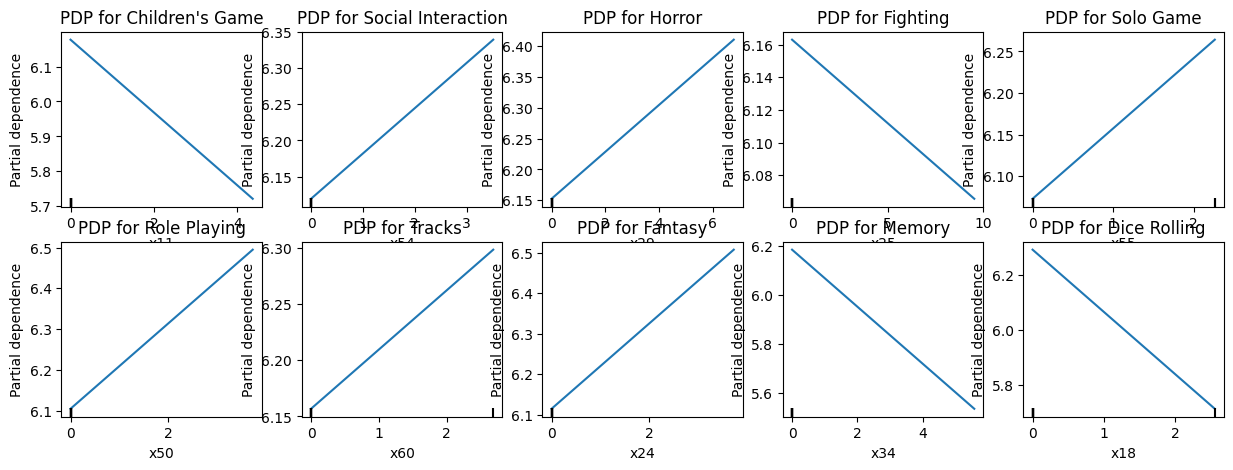

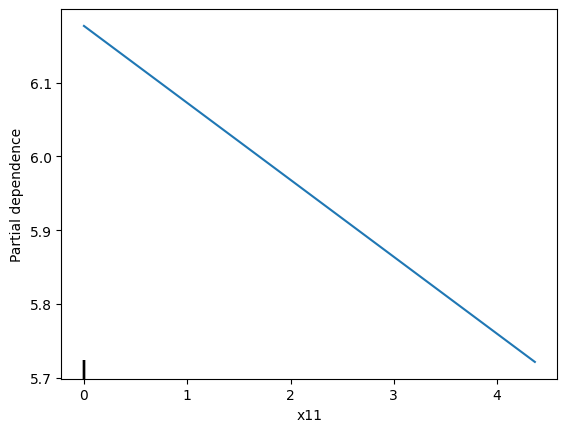

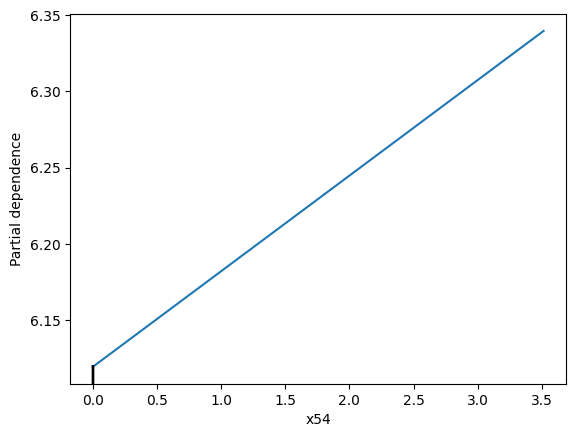

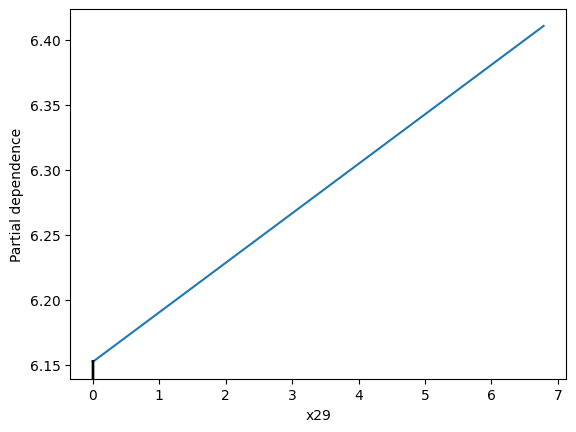

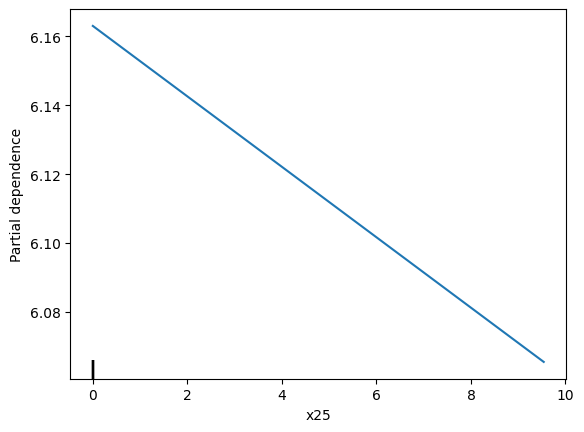

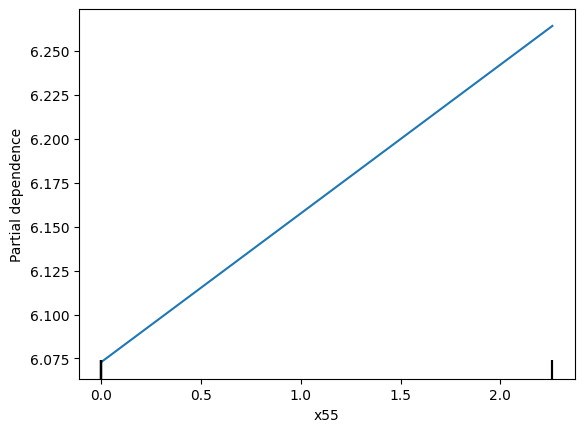

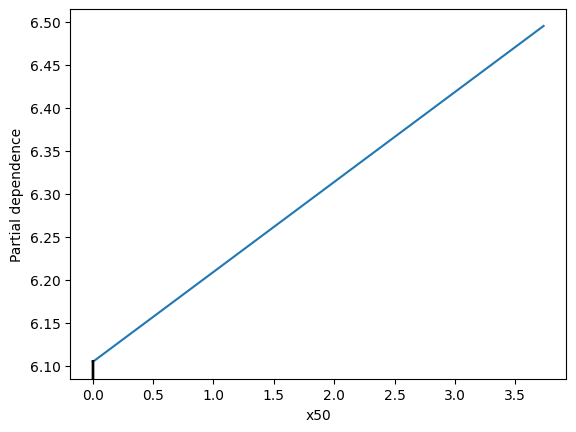

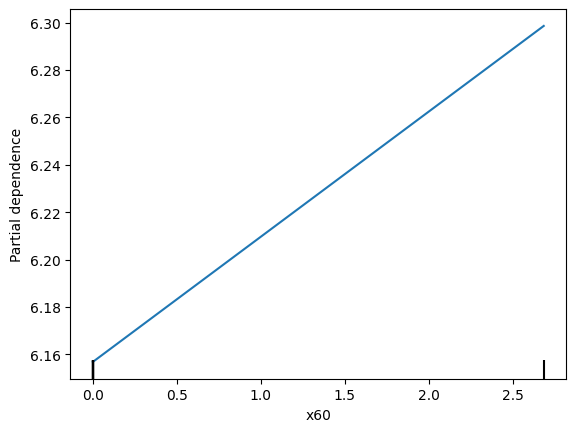

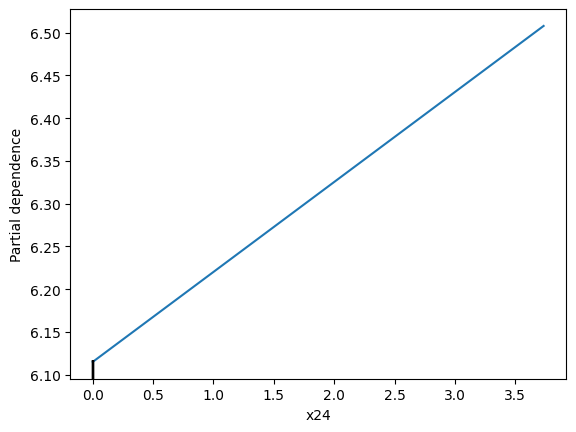

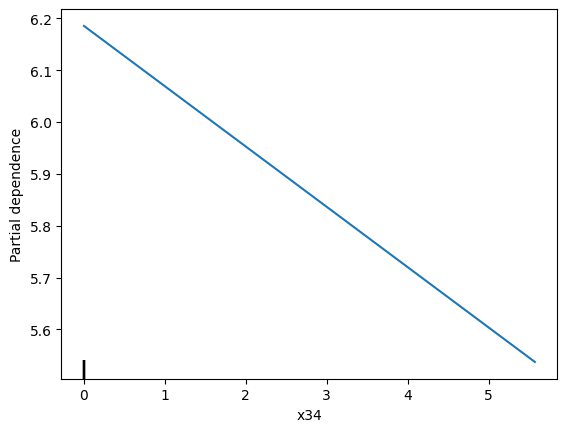

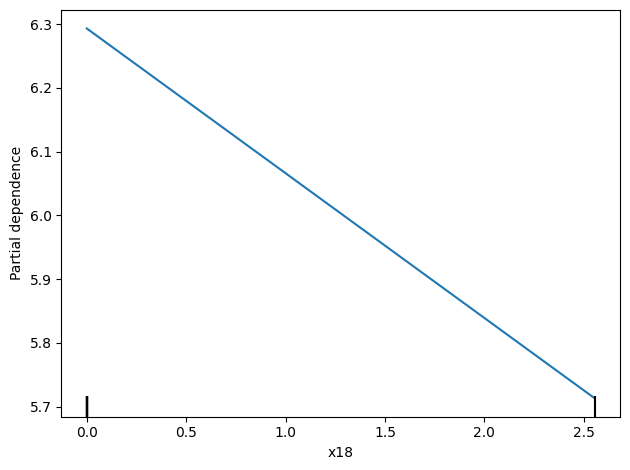

In [64]:
# Get the indices of the top 10 most relevant features
selected_feature_indices = feature_importance_df.head(top_N_features).index

# Create a subplot for each feature
num_rows = 2
num_cols = 5
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5))

# Flatten the subplots array for easier iteration
axs = axs.flatten()

# Iterate over the selected feature indices
for i, feature_index in enumerate(selected_feature_indices):
    # Get feature name
    feature_name = feature_importance_df.iloc[i,0]
    
    # Create PartialDependenceDisplay object for the current feature
    pd_display = PartialDependenceDisplay.from_estimator(best_model_RS1, X_train_preprocessed, features=[feature_index])

    # Plot partial dependence on the corresponding subplot
    pd_display.plot(ax=axs[i])
    axs[i].set_ylabel('Partial Dependence')
    axs[i].set_xlabel('Feature Values')
    axs[i].set_title(f'PDP for {feature_name}')

    # Remove individual feature pdp plot
    axs[i].get_children()[2].set_visible(False)

# Hide the remaining empty subplots
for j in range(len(selected_feature_indices), num_rows * num_cols):
    axs[j].set_visible(False)

# Adjust subplot spacing and display the plots
plt.tight_layout()
plt.show()

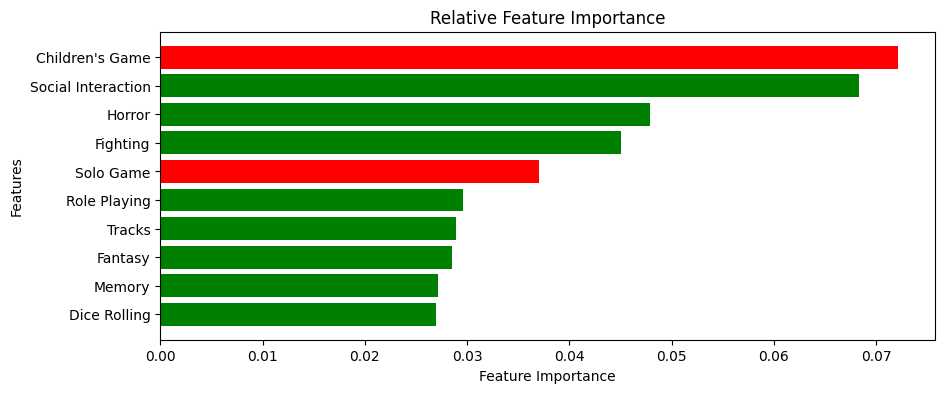

In [65]:
# Assign the positive or negative influence for a better display of the realtive feature importance bar chart
top_10_influence = ['neg','pos','pos','pos','neg','pos','pos','pos','pos','pos']
top_10_influence_colors = ['r' if influence == 'neg' else 'g' for influence in top_10_influence ]

top_10_influence_colors.reverse()

# Plot the feature importance
plt.figure(figsize=(10, 4))
plt.barh(top_feature_importance_df['Feature'], top_feature_importance_df['Importance'], color=top_10_influence_colors)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Relative Feature Importance")
plt.show()

As we can see the main features that seem to impact my rating are the fact it is a Children's game or not, having a preference for those that are not, since indeed I do prefer adult games. 

Surprisingly,  horror, fighting and role playing seem to have an positive influence on the rating given by the model while I don't think I particularly give any attention to these. 

Finally, Tracks does feature as one of the top 10 most impactful and positive features which is indeed one the traits I do enjoy the most about games.

#### 6.4. Specific results and explaining
##### 6.4.1. Deep dive on specific results
Let's have a look at some specific board games and the results of our model. We want to find and analyze more in details a highly rated game I rated, and didn't rate, and same for a lowly rated game. Then we'll look at the factors that contributed to the final rating and explain them with a SHAP analysis.

In [66]:
# Let's have a look at some popular games that the model predicts having a low rating for me
final_df_slim[final_df_slim['rank']<= 300].sort_values(by=['prediction_final','rank'], ascending = [True,True]).head(10)

,bgg_id,name,rank,avg_rating,complexity,YourRating,players_best,prediction_final,Game Description
48473,160477,Onitama,284.0,7.36185,1.6739,NaN,2.0,2.48,"Abstract Strategy; Combat and Conflict; Deck, ..."
66112,260605,Camel Up (Second Edition),260.0,7.60613,1.4700,NaN,6.0,3.02,Animals; Bluffing; Dice; Dice Rolling; Sports;...
49117,163412,Patchwork,110.0,7.60811,1.6094,NaN,2.0,3.38,Abstract Strategy; Drafting; Economic; Game Pr...
71534,291453,SCOUT,185.0,7.79881,1.3517,NaN,4.0,3.66,"Bluffing; Card Game; Deck, Bag, and Pool Build..."
60873,230802,Azul,70.0,7.76172,1.7613,NaN,2.0,3.78,Abstract Strategy; Drafting; End Game Bonuses;...
62775,242302,Space Base,189.0,7.55882,2.1126,NaN,4.0,3.85,Dice; Dice Rolling; Drafting; Resource Managem...
10362,14105,Commands & Colors: Ancients,187.0,7.77093,2.6927,NaN,2.0,3.99,"Campaign Game; Combat and Conflict; Deck, Bag,..."
14723,20551,Shogun,245.0,7.52291,3.3658,NaN,5.0,4.04,Auction/Bidding; Control; Economic; Historical...
30134,54043,Jaipur,164.0,7.49113,1.4688,NaN,2.0,4.09,"Animals; Asymetric Powers; Card Game; Deck, Ba..."
29754,48726,Alien Frontiers,299.0,7.37398,2.5664,NaN,4.0,4.14,Control; Dice; Dice Rolling; Drafting; Science...


In [67]:
bad_known_board_game_name = 'UNO'
good_known_board_game_name = 'Ark Nova'
popular_recommended_game_name = 'Lisboa'
popular_not_recommended_game_name = 'Patchwork'
game_for_tonight_name = 'Woodcraft'

bad_known_board_game_row_position = final_df.loc[final_df['name'] == bad_known_board_game_name].index[0]
good_known_board_game_row_position = final_df.loc[final_df['name'] == good_known_board_game_name].index[0]
popular_recommended_game_row_position = final_df.loc[final_df['name'] == popular_recommended_game_name].index[0]
popular_not_recommended_game_row_position = final_df.loc[final_df['name'] == popular_not_recommended_game_name].index[0]
game_for_tonight_row_position = final_df.loc[final_df['name'] == game_for_tonight_name].index[0]

# Print the dataframe slice containing the selected games to analyse
selected_games_names = [bad_known_board_game_name, good_known_board_game_name, popular_recommended_game_name, popular_not_recommended_game_name, game_for_tonight_name]
selected_games_indices = [bad_known_board_game_row_position,good_known_board_game_row_position,popular_recommended_game_row_position,popular_not_recommended_game_row_position, game_for_tonight_row_position]
selected_games = dict(zip(selected_games_indices, selected_games_names))

final_df_slim[final_df_slim.index.isin(selected_games_indices)]

,bgg_id,name,rank,avg_rating,complexity,YourRating,players_best,prediction_final,Game Description
1598,2223,UNO,24240.0,5.43399,1.1086,2.5,5.0,4.60,Book; Card Game; Children's Game; Combat and C...
48696,161533,Lisboa,58.0,8.18995,4.5946,NaN,3.0,8.19,"Control; Deck, Bag, and Pool Building; Draftin..."
49117,163412,Patchwork,110.0,7.60811,1.6094,NaN,2.0,3.38,Abstract Strategy; Drafting; Economic; Game Pr...
82546,342942,Ark Nova,4.0,8.53405,3.7249,9.0,2.0,8.31,"Animals; Asymetric Powers; Deck, Bag, and Pool..."
85488,355093,Woodcraft,736.0,7.82997,3.8284,8.0,3.0,7.81,Dice Rolling; Economic; End Game Bonuses; Fant...


##### 6.4.2. SHAP Analysis
Now let's build some SHAP plots to take a closer look at those 4 games and why the rating outcome is such.

In [68]:
# Defining the shap explainer function
model = best_model_RS1 
explainer = shap.Explainer(best_model_RS1)
# Using the preprocessed feature data for the shap values calculation
feature_data = features_final
shap_values = explainer.shap_values(features_final_preprocessed)

# Defining a custom formatter function to show values as Yes or No instead of 0 and 1 on the shap graph, for ease of understanding
def binary_formatter(feature_values):
    return ['No' if value == 0 else 'Yes' if value == 1 else value for value in feature_values]

# Modify feature values using the custom formatter
modified_features = feature_data.copy()
modified_features = modified_features.apply(binary_formatter)

# Loading the features of the specific data point we want to analyze (for now a bad known board game, UNO)
data_point_bad_known = modified_features.iloc[bad_known_board_game_row_position]

# Plotting the shap.force plot explainer graph for UNO
shap.force_plot(explainer.expected_value, shap_values[bad_known_board_game_row_position], data_point_bad_known, matplotlib=True, show=False)
plt.title("SHAP explainer graph for a known 'bad' board game: "+bad_known_board_game_name)

Text(0.5, 1.0, "SHAP explainer graph for a known 'bad' board game: UNO")

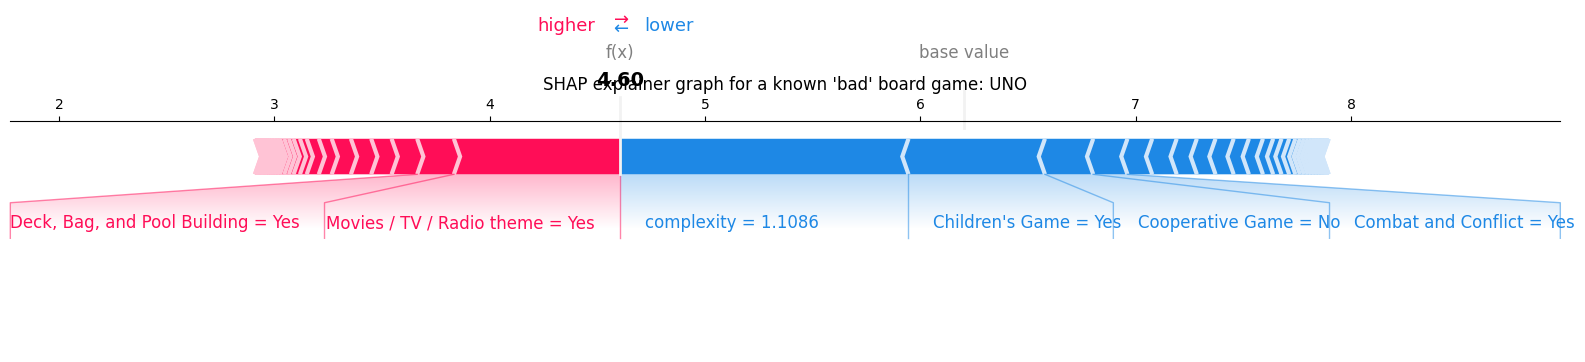

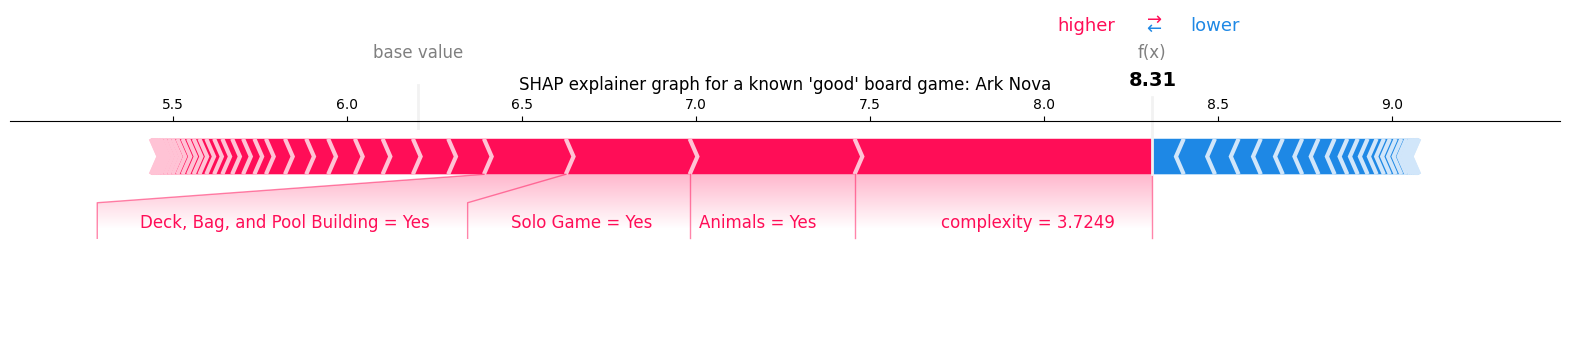

In [69]:

# Loading the features of the specific data point we want to analyze (for now a good known board game, Ark Nova)
data_point_good_known = modified_features.iloc[good_known_board_game_row_position]

# Plotting the shap.force plot explainer graph for Ark Nova
shap.force_plot(explainer.expected_value, shap_values[good_known_board_game_row_position], data_point_good_known, matplotlib=True, show=False)
plt.title("SHAP explainer graph for a known 'good' board game: "+good_known_board_game_name)
plt.show()

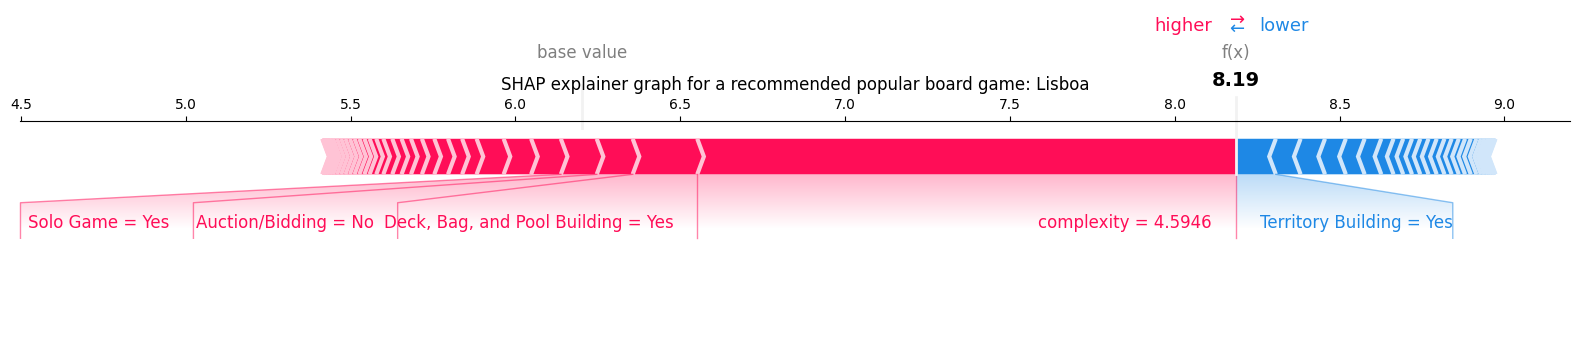

In [70]:

# Loading the features of the specific data point we want to analyze (for now a recommended board game, Lisboa)
data_point_popular_rec = modified_features.iloc[popular_recommended_game_row_position]

# Plotting the shap.force plot explainer graph for Caverna
shap.force_plot(explainer.expected_value, shap_values[popular_recommended_game_row_position], data_point_popular_rec, matplotlib=True, show=False)
plt.title("SHAP explainer graph for a recommended popular board game: "+popular_recommended_game_name)
plt.show()

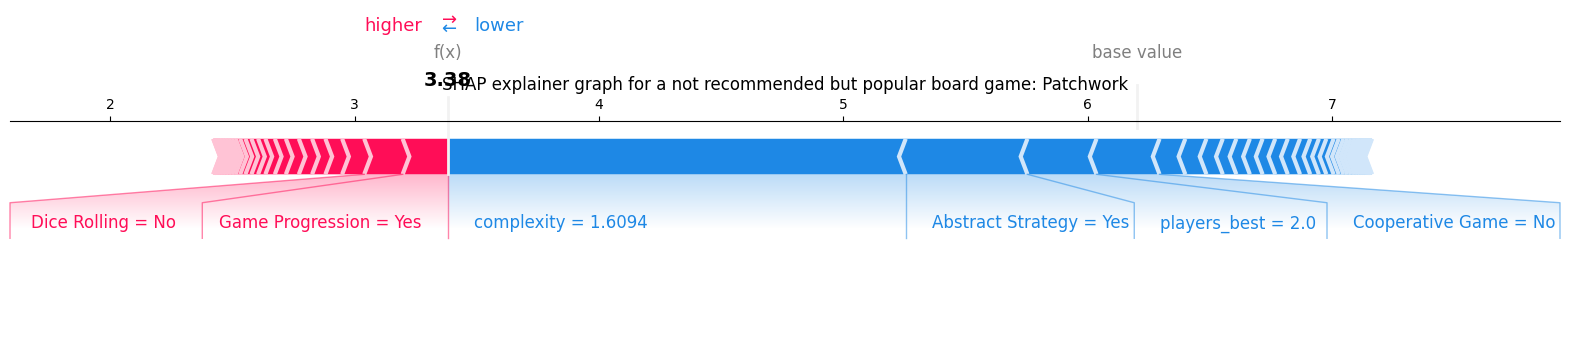

In [71]:

# Loading the features of the specific data point we want to analyze (for now a not recommended board game, Patchwork)
data_point_popular_not_rec = modified_features.iloc[popular_not_recommended_game_row_position]

# Plotting the shap.force plot explainer graph for Ra
shap.force_plot(explainer.expected_value, shap_values[popular_not_recommended_game_row_position], data_point_popular_not_rec, matplotlib=True, show=False)
plt.title("SHAP explainer graph for a not recommended but popular board game: "+popular_not_recommended_game_name)
plt.show()

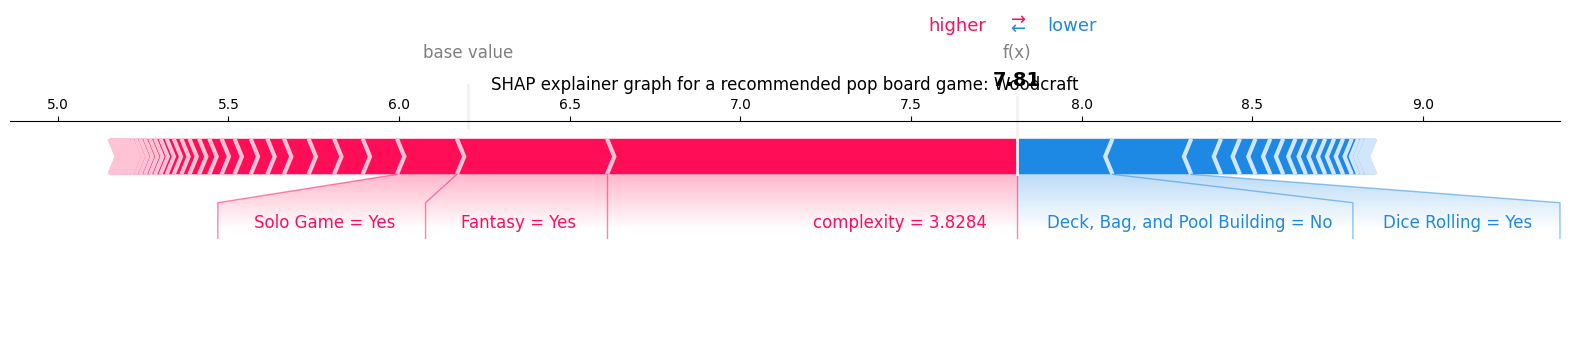

In [72]:

# Loading the features of the specific data point we want to analyze (for a game I will play tonight, Woodcraft)
data_point_game_tonight = modified_features.iloc[game_for_tonight_row_position]

# Plotting the shap.force plot explainer graph for Ra
shap.force_plot(explainer.expected_value, shap_values[game_for_tonight_row_position], data_point_game_tonight, matplotlib=True, show=False)
plt.title("SHAP explainer graph for a recommended pop board game: "+game_for_tonight_name)
plt.show()

#### 6.4.3. Result discussion

Plotting the SHAP analysis graphs helps to understand why certain games get such or such rating and what impacts the most the final rating.

- A 'bad' known board game for me: UNO

Being a low complexity game that is classified as "Children's game" very negatively impacts the rating UNO gets. Furthermore, one of the only positive traits increasing the rating is "Deck, Pool, Bag Building", which was most likely mis-assigned due to the game having a deck of cards as it not really a deck building game, should mean that the rating would be even lower for that game.


- A 'good' know board game for me: Ark Nova

A high complexity game, with a theme that I like (Animals) and some tile placement mean that Ark Nova gets a high rating. We have to temper the rating as the 'Deck buidling' trait is not the main feature of the game.

- A recommended popular game unknown to me: Lisboa

Again, a complex game with deck building and tile placement, means I should like this game. Very few traits are negatively impacting the result, one of them being Territory Building, which is indeed, not my favourite mechanic.

- A not recommended though popular game unknown to me: Patchwork

A low complexity game, with some of my favourite mechanics absent, means I'm unlikely to enjoy it too much.

- A game I am playing tonight: Woodcraft

This looks like a good pick, with high complexity, and end game bonuses. The presence of dice rolling, a random component I tend to dislike, makes it so it would probably not be one of my all-time favourite games but it still gets a high predicted rating of 7.81.


### 7. Conclusion

This project has been a tentative at a recommender system to give myself some recommendations of games I would enjoy based on traits such as game complexity, mechanics and categories. The main obstacle to a reliable prediction and model building is that the target metric, my own rating, is subjective and some games having a certain theme or mechanic could be rated high in some cases and low in others because of other factors, some of them where discarded in this project due to complexity of analysis or incomplete data (e.g. designer, artist, publisher...). External factors, such as mood, people I played with, how I overall did at the game (playing well or badly) could have an impact on my subjective rating but obviously cannot be captured my the moddel. Finally, the small sample size of game with the target feature present (~110 games) compared to the overall list of games (~90k) means the data used for training of this unsupervised model is likely to cause underfitting when training (and testing) the model.